In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
seed = 0
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [3]:
df['NObeyesdad'] = df['NObeyesdad'].map({'Insufficient_Weight':0,
                                           'Normal_Weight':0,
                                           'Overweight_Level_I':1,
                                           'Overweight_Level_II':1,
                                           'Obesity_Type_I':1,
                                           'Obesity_Type_II':1,
                                           'Obesity_Type_III':1})
df['NObeyesdad'].value_counts()

NObeyesdad
1    1552
0     559
Name: count, dtype: int64

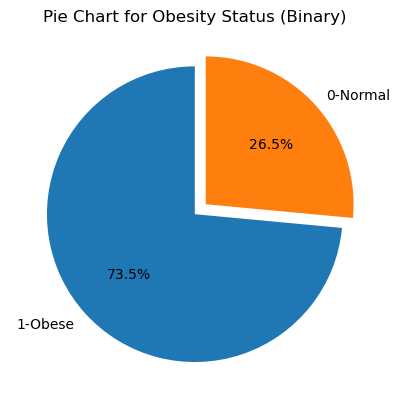

In [4]:
# pie chart for the Obesity_binary column
plt.pie(df['NObeyesdad'].value_counts(), labels=['1-Obese','0-Normal'],
        startangle=90, explode=[0, 0.1], autopct='%1.1f%%')

plt.title("Pie Chart for Obesity Status (Binary)")
plt.show()


In [5]:
def chi_square(c1, c2, alpha=.05):
    res = []
    for col in c1:
        crosstab = np.array(pd.crosstab(c1[col], c2, margins=False))
        chi_sq, p_val, *a = chi2_contingency(crosstab)
        cram_V = np.sqrt(chi_sq / (np.sum(crosstab) * (min(crosstab.shape)-1)))
        if p_val < alpha:
            corr = "Yes"
        else:
            corr = "No"
        entry = {'Var1': col, 'Var2': c2.name, 'Correlated': corr, 'alpha': alpha, 'p_val': round(p_val, 3), "Cramer's V": round(cram_V, 3)}
        res.append(entry)
    return pd.DataFrame(res)


chi_square(df.select_dtypes('object'), df['NObeyesdad'], alpha=0.01)

,Var1,Var2,Correlated,alpha,p_val,Cramer's V
0,Gender,NObeyesdad,Yes,0.01,0.000,0.080
1,family_history_with_overweight,NObeyesdad,Yes,0.01,0.000,0.488
2,FAVC,NObeyesdad,Yes,0.01,0.000,0.217
3,CAEC,NObeyesdad,Yes,0.01,0.000,0.507
4,SMOKE,NObeyesdad,No,0.01,0.523,0.014
5,SCC,NObeyesdad,Yes,0.01,0.000,0.134
6,CALC,NObeyesdad,Yes,0.01,0.000,0.135
7,MTRANS,NObeyesdad,Yes,0.01,0.000,0.178


In [6]:
# copy of the original DataFrame
df = df.copy()

In [7]:
# dropping columns
df.drop(columns=['Weight','SMOKE'], inplace=True)

In [8]:
# Encoding 'Gender' as binary
df['Gender'] = df.Gender.map({'Male':0, 'Female':1}).astype('uint8')
# Encoding binary columns (yes/no)
for col in ['family_history_with_overweight','FAVC','SCC']:
    df[col] = df[col].map({'no':0, 'yes':1}).astype('uint8')
# Encoding ordinal columns    
for col in ['CAEC','CALC']:
    df[col] = df[col].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3}).astype('uint8')
# One-hot encoding for transportation used    
df = pd.get_dummies(df, columns=['MTRANS'], drop_first=True)
df.head()

,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,21.0,1.62,1,0,2.0,3.0,1,2.0,0,0.0,1.0,0,0,False,False,True,False
1,1,21.0,1.52,1,0,3.0,3.0,1,3.0,1,3.0,0.0,1,0,False,False,True,False
2,0,23.0,1.80,1,0,2.0,3.0,1,2.0,0,2.0,1.0,2,0,False,False,True,False
3,0,27.0,1.80,0,0,3.0,3.0,1,2.0,0,2.0,0.0,2,1,False,False,False,True
4,0,22.0,1.78,0,0,2.0,1.0,1,2.0,0,0.0,0.0,1,1,False,False,True,False


In [9]:
# Separate the features (X) and the target variable (y)
X = df.drop(columns='NObeyesdad')
y = df['NObeyesdad']

# splitting train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

# scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_sc_train = sc.fit_transform(X_train)
X_sc_test = sc.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1583, 17) (528, 17) (1583,) (528,)


In [10]:
pd.DataFrame(X_sc_train, columns=X.columns).describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Gender,1583.0,0.49,0.50,0.0,0.00,0.00,1.00,1.0
Age,1583.0,0.25,0.15,0.0,0.14,0.21,0.29,1.0
Height,1583.0,0.45,0.19,0.0,0.30,0.45,0.59,1.0
family_history_with_overweight,1583.0,0.81,0.39,0.0,1.00,1.00,1.00,1.0
FAVC,1583.0,0.88,0.33,0.0,1.00,1.00,1.00,1.0
FCVC,1583.0,0.71,0.26,0.0,0.50,0.69,1.00,1.0
NCP,1583.0,0.56,0.26,0.0,0.55,0.67,0.67,1.0
CAEC,1583.0,0.38,0.15,0.0,0.33,0.33,0.33,1.0
CH2O,1583.0,0.51,0.30,0.0,0.31,0.50,0.74,1.0
SCC,1583.0,0.04,0.20,0.0,0.00,0.00,0.00,1.0


In [25]:
# Global report DataFrame to store results
report = pd.DataFrame(columns=["Model", "Accuracy"])
def get_best_clasification_report(model, params):
    # RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(model, params, random_state=seed).fit(
        X_train, y_train)
    # predictions with the best model found by RandomizedSearchCV  
    y_pred = random_search.best_estimator_.predict(X_test)
    # Calculate and store the F1 score for the best model
    report.loc[len(report)] = [model.__str__()[:-2], f1_score(y_test, y_pred, average='micro')]
    # Print the best hyperparameters
    print(f"Best params for {model}: {random_search.best_params_}")
    print(classification_report(y_test, y_pred))
    # Return the best model found
    return random_search.best_estimator_

In [27]:
# Hyperparameter grid for Logistic Regression
log_params = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.1, 1, 10],
    "max_iter": [100, 500, 1000],
}

_ = get_best_clasification_report(LogisticRegression(), log_params)

Best params for LogisticRegression(): {'penalty': 'l2', 'max_iter': 500, 'C': 1}
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       140
           1       0.90      0.92      0.91       388

    accuracy                           0.86       528
   macro avg       0.83      0.81      0.82       528
weighted avg       0.86      0.86      0.86       528



In [29]:
# Hyperparameter grid for Random Forest Classifier
rf_params = {
    "n_estimators": [100, 110, 120],
    "min_samples_split": [4, 5],
    "min_samples_leaf": [4, 5],
}


rf = get_best_clasification_report(RandomForestClassifier(), rf_params)

Best params for RandomForestClassifier(): {'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 4}
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       140
           1       0.95      0.94      0.94       388

    accuracy                           0.92       528
   macro avg       0.89      0.90      0.90       528
weighted avg       0.92      0.92      0.92       528



In [31]:
# Hyperparameter grid for Gradient Boosting Classifier
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7],
}

gb = get_best_clasification_report(GradientBoostingClassifier(), gb_params)

Best params for GradientBoostingClassifier(): {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       140
           1       0.93      0.96      0.95       388

    accuracy                           0.92       528
   macro avg       0.91      0.88      0.89       528
weighted avg       0.92      0.92      0.92       528



In [32]:
report.sort_values('Accuracy', ascending=False)

,Model,Accuracy
1,RandomForestClassifier,0.918561
2,GradientBoostingClassifier,0.918561
0,LogisticRegression,0.861742


<Figure size 500x400 with 0 Axes>

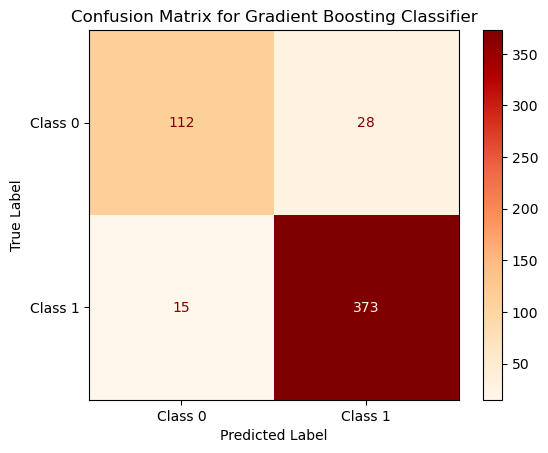

In [35]:
# Generate predictions
y_pred = gb.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix 
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='OrRd', values_format='d', colorbar=True)
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()